# Классификация видео с помощью 3D сверточной нейронной сети

Руководство по обучению 3D сверточной нейронной сети (CNN) для классификации видео с использованием набора данных для распознавания действий UCF101: (https://www.crcv.ucf.edu/data/UCF101.php). 3D CNN использует трехмерный фильтр для выполнения свертки. Ядро способно перемещаться в трех направлениях, тогда как в 2D CNN оно может перемещаться в двух измерениях. Модель основана на работе, опубликованной в работе "Более пристальный взгляд на пространственно-временные свертки для распознавания действий" (https://arxiv.org/abs/1711.11248v3).

1) Построение входного конвейера
2) Постройте 3D-модель сверточной нейронной сети с остаточными связями, используя Keras functional API
3) Обучаем модель
4) Оцените и протестируйте модель

Другие руководства:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): моделями MoViNet, доступные на TF Hub
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): руководство о том, как использовать предварительно обученную модель классификации видео, обученную на другом наборе данных с набором данных UCF-101.

## Импорт библиотек

In [19]:
import sys
import os
import pathlib
import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
import collections

import cv2
import einops # для тензонрых преобразоаний
import imageio
import remotezip as rz

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed

In [20]:
sys.path.append('D:/Programming/Python')

In [21]:
from ml_tools import training_plot

## Загруска исходного датасета

Вспомогательные функции для загрузки фрагмента данных из набора данных UCF-101 и загрузки его в tf.data.Dataset. 

Более подробно смотри тут: [Учебное руководство по загрузке видеоданных](../load_data/video.ipynb).

Класс FrameGenerator создает итерируемый объект, который может передавать данные в конвейер данных TensorFlow. В частности, этот класс содержит генератор Python, который загружает видеокадры вместе с их закодированной меткой. Функция генератора (`__call__`) возвращает массив кадров, созданный с помощью `frames_from_video_file`, и вектор метки, закодированный в горячем виде, связанный с набором кадров.

In [22]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

Проверка содержимого zip-файла по этому URL-адресу

In [23]:
def list_files_from_zip_url(zip_url: str):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [24]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

Извлечение имяни класса из имени файла

In [25]:
def get_class(fname):
  return fname.split('_')[-3]

Преобразование списка всех файлов в словарь со списком файлов для каждого класса

In [26]:
def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [27]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


Разделение видео на обучающие, проверочные и тестовые наборы. Видео загружаются по URL-адресу с zip-файлом и помещаются в соответствующие подкаталоги.

In [28]:
def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file, )

Функция, которая возвращает оставшиеся данные, которые еще не были помещены в подмножество данных. 
Это позволяет вам поместить эти оставшиеся данные в следующее указанное подмножество данных.

In [29]:
def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

Загрузка подмножества набора данных UCF101 и разделение его на обучающий, проверочный и тестовый наборы. 
Можно указать количество классов, которые вы хотели бы использовать. 
Аргумент splits позволяет вам передать словарь, в котором ключевыми значениями являются название подмножества (пример: "train") и количество видео, которые вы хотели бы иметь в каждом классе.

In [30]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
    
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [31]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [32]:
download_dir = os.path.abspath('./UCF101_subset/')
download_dir

'd:\\Programming\\projects\\ML\\videos\\classification\\video_classification\\UCF101_subset'

In [33]:
download_dir = pathlib.Path('./UCF101_subset/')
download_dir

WindowsPath('UCF101_subset')

In [34]:
os.listdir()

['videos', 'video_classification.ipynb', '.git', '.gitignore', 'animation.gif']

In [35]:
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir=download_dir)

train :


100%|██████████| 300/300 [04:32<00:00,  1.10it/s]


val :


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


test :


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


In [36]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


`frames_from_video_file` Функция разбивает видео на кадры, считывает случайно выбранный интервал n_frames из видеофайла и возвращает их в виде NumPy array. 
Чтобы сократить объем памяти и вычислительные издержки, выбирайте небольшое количество кадров. 
Кроме того, выберите одинаковое количество кадров из каждого видео, что упрощает работу с пакетами данных.

In [80]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()

  return np.array(result)

## Визуализация данных

In [81]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


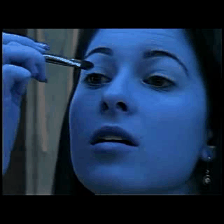

In [82]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

## Импорт исходного датасета

Класс, который может передавать данные в конвейер данных TensorFlow. 
Функция generator (__call__) выдает массив кадров, созданный с помощью frames_from_video_file, и вектор метки в однократном кодировании, связанный с набором кадров.

In [124]:
class FrameGenerator:
  def __init__(self, path, n_frames, training=False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [125]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 1


Конвейер ввода данных TensorFlow. 
Этот конвейер, который вы создаете на основе объекта generator, позволяет вам вводить данные в вашу модель глубокого обучения. 
В этом видеопотоке каждый элемент представляет собой отдельный набор кадров и связанную с ним метку.

In [126]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

In [127]:
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True), output_signature=output_signature)

Убедитесь, что метки перемешаны.

In [128]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)


## Разделение данных

In [129]:
# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [130]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


## Создание модели

Следующая трехмерная сверточная модель нейронной сети основана на статье ["Более пристальный взгляд на пространственно-временные свертки для распознавания действий"] (https://arxiv.org/abs/1711.11248v3) Д. Трана и др. (2017). В статье сравниваются несколько версий 3D-ресетей. Вместо того, чтобы работать с одним изображением с размерами "(высота, ширина)", как в стандартных ресетях, они работают с объемом видео `(время, высота, ширина)`. Наиболее очевидным подходом к решению этой проблемы была бы замена каждой двумерной свертки (`layers.Conv2D`) на трехмерную свертку (`layers.Conv3D`).

Здесь используется (2 + 1)-мерная свертка с [остаточными связями (residual connections)](https://arxiv.org/abs/1512.03385). (2 + 1)-мерная свертка позволяет разложить пространственные и временные измерения, таким образом, создавая два отдельных этапа. Преимущество этого подхода заключается в том, что разложение сверток на пространственные и временные измерения позволяет экономить параметры.

Для каждого выходного местоположения 3D-свертка объединяет все векторы из 3D-фрагмента объема, чтобы создать один вектор в выходном объеме.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

Эта операция использует входные данные "time", "height", "width", "channels" и выдает выходные данные "channels" (при условии, что количество входных и выходных каналов одинаково. Таким образом, для слоя трехмерной свертки с размером ядра "(3 x 3 x 3)" потребуется весовая матрица с записями "27 * каналов ** 2". В справочном документе было обнаружено, что более эффективным подходом является факторизация свертки. Вместо единой трехмерной свертки для обработки временных и пространственных измерений они предложили свертку "(2+1)D", которая обрабатывает пространственные и временные измерения по отдельности. На рисунке ниже показаны учтенные пространственная и временная свертки (2 + 1)D-свертки.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

Главное преимущество такого подхода заключается в том, что он сокращает количество параметров. В (2 + 1)-мерной свертке пространственная свертка принимает данные формы "(1, ширина, высота)", в то время как временная свертка принимает данные формы "(время, 1, 1)". Например, для (2 + 1) D-свертки с размером ядра "(3 x 3 x 3)" потребуются весовые матрицы размером "(9 * каналов ** 2) + (3 * каналов ** 2)", что в два раза меньше, чем для полной 3D-свертки. В этом руководстве реализована (2 + 1) разнесенная сеть ResNet18, где каждая свертка в сети resnet заменяется (2+1)разнесенной сверткой.

In [131]:
# Define the dimensions of one frame in the set of frames created
WIDTH, HEIGHT = 224, 224

In [132]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

Модель ResNet создается на основе последовательности остаточных блоков.
Остаточный блок состоит из двух ветвей. Основная ветвь выполняет вычисления, но ее градиенты затрудняют прохождение.
Остаточная ветвь обходит основные вычисления и в основном просто добавляет входные данные к выходным данным основной ветви.
Градиенты легко проходят через эту ветвь.
Таким образом, будет обеспечен простой путь от функции потерь к любой основной ветви остаточного блока.
Это позволяет избежать проблемы с исчезающим градиентом.

Создайте основную ветвь остаточного блока со следующим классом. В отличие от стандартной структуры ResNet, здесь используется пользовательский слой "Conv2Plus1D" вместо "слоев".Conv2D.

In [95]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

Чтобы добавить остаточную ветвь к основной, она должна иметь тот же размер. Слой "Project", расположенный ниже, описывает случаи, когда количество каналов в ветви изменяется. В частности, добавляется последовательность плотно соединенных слоев с последующей нормализацией.

In [96]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Используется `add_residual_block`, чтобы ввести пропускное соединение между слоями модели.

In [97]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Изменение размера видео необходимо для уменьшения выборки данных. В частности, уменьшение выборки видеокадров позволяет модели исследовать определенные части кадров для выявления закономерностей, которые могут быть характерны для определенного действия. За счет уменьшения дискретизации несущественная информация может быть отброшена. Кроме того, изменение размера видео позволит уменьшить размерность и, следовательно, ускорить обработку модели.

In [98]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

[API Keras](https://www.tensorflow.org/guide/keras/functional) для построения остаточной сети.

In [99]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [100]:
frames, label = next(iter(train_ds))
model.build(frames)

## Обучение модели

Для этого выберается оптимизатор tf.keras.optimizers.Adam и функцию потерь tf.keras.losses.SparseCategoricalCrossentropy.

In [101]:
epochs = 5 # 50

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [102]:
history = model.fit(x = train_ds,
                    epochs = epochs, 
                    validation_data = val_ds)

Epoch 1/5
     38/Unknown 11s 11s/step - accuracy: 0.2500 - loss: 2.3714s 3s/step - accuracy: 0.1875 - loss: 2.442217s 3s/step - accuracy: 0.1528 - loss: 2.45020s 3s/step - accuracy: 0.1380 - loss: 2.46624s 3s/step - accuracy: 0.1304 - loss: 2.47227s 3s/step - accuracy: 0.1260 - loss: 2.47130s 3s/step - accuracy: 0.1259 - loss: 2.45934s 3s/step - accuracy: 0.1297 - loss: 2.44637s 3s/step - accuracy: 0.1307 - loss: 2.44240s 3s/step - accuracy: 0.1314 - loss: 2.43944s 3s/step - accuracy: 0.1318 - loss: 2.43747s 3s/step - accuracy: 0.1313 - loss: 2.43850s 3s/step - accuracy: 0.1300 - loss: 2.44454s 3s/step - accuracy: 0.1284 - loss: 2.45057s 3s/step - accuracy: 0.1276 - loss: 2.45360s 3s/step - accuracy: 0.1270 - loss: 2.45664s 3s/step - accuracy: 0.1264 - loss: 2.45867s 3s/step - accuracy: 0.1256 - loss: 2.45970s 3s/step - accuracy: 0.1252 - loss: 2.45974s 3s/step - accuracy: 0.1252 - loss: 2.45977s 3s/step - accuracy: 0.1252 - loss: 2.45980s 3s/step - accuracy: 0.1249 - loss: 2.45883s 3

c:\Python\Python 3.11.8\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.1334 - loss: 2.4378 - val_accuracy: 0.1500 - val_loss: 2.2949
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - accuracy: 0.1250 - loss: 2.356 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - accuracy: 0.1875 - loss: 2.182 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.2222 - loss: 2.148 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - accuracy: 0.2448 - loss: 2.126 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - accuracy: 0.2608 - loss: 2.106 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - accuracy: 0.2625 - loss: 2.104 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - accuracy: 0.2582 - loss: 2.111 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step - accuracy: 0.2513 - loss: 2.123 ━━━━━━━━━━━━━━━━━━━━ 1:20 3s/step - accuracy: 0.2450 - loss: 2.137 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - accuracy: 0.2380 - loss: 2.159 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - accuracy: 0.2318 - loss: 2.174 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.2255 - loss: 2.186 ━━━━━━━━━━━━━━━━━━━━ 1:10 3s/step - accuracy: 0.2200 - loss: 2.1

### Результат обучения

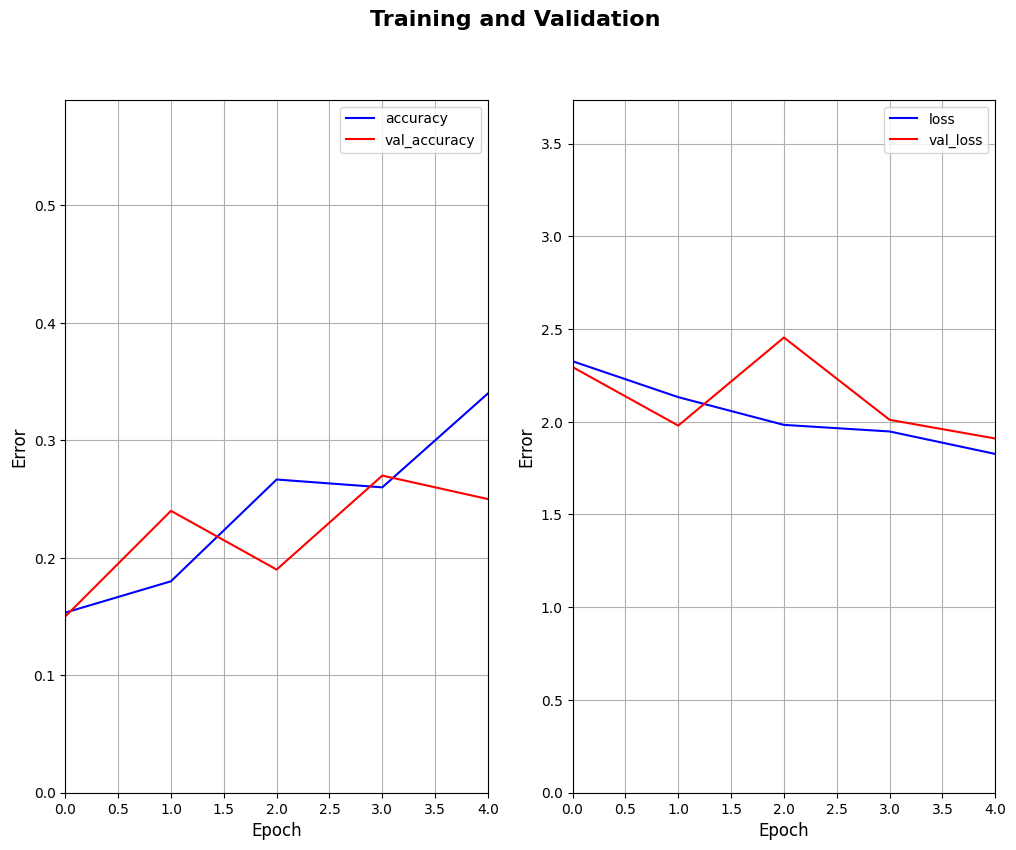

In [103]:
training_plot(history)

## Оценка модели

Используйте Keras "Model.evaluate", чтобы получить данные о потерях и точности в тестовом наборе данных. 

Примечание: В примере модели в этом руководстве используется подмножество набора данных UCF101, чтобы сократить время обучения. Точность и потери могут быть улучшены с помощью дальнейшей настройки гиперпараметров или увеличения объема обучающих данных.

In [104]:
model.evaluate(test_ds, return_dict=True)

13/1313/Unknown 1s 1s/step - accuracy: 0.2500 - loss: 1.572s 1s/step - accuracy: 0.1875 - loss: 1.624s 1s/step - accuracy: 0.1806 - loss: 1.705s 1s/step - accuracy: 0.1745 - loss: 1.826s 1s/step - accuracy: 0.1796 - loss: 1.867s 1s/step - accuracy: 0.1774 - loss: 1.918s 1s/step - accuracy: 0.1725 - loss: 1.969s 1s/step - accuracy: 0.1685 - loss: 2.0010s 1s/step - accuracy: 0.1698 - loss: 2.02711s 1s/step - accuracy: 0.1779 - loss: 2.03412s 1s/step - accuracy: 0.1855 - loss: 2.03813s 1s/step - accuracy: 0.1934 - loss: 2.03613s 1s/step - accuracy: 0.2009 - loss: 2.032 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2072 - loss: 2.0184


{'accuracy': 0.28999999165534973, 'loss': 1.839808702468872}

Для дальнейшей визуализации производительности модели используйте [матрицу путаницы](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). Матрица путаницы позволяет оценить производительность классификационной модели за пределами точности. Чтобы построить матрицу путаницы для этой задачи многоклассовой классификации, получите фактические значения в тестовом наборе и прогнозируемые значения.

In [105]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [106]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [107]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

38/3838/Unknown 1s 1s/st2s 834ms/ste3s 909ms/ste4s 919ms/ste5s 924ms/ste6s 929ms/ste8s 1s/step 9s 1s/st10s 1s/ste11s 1s/ste12s 1s/ste13s 1s/ste14s 1s/ste15s 1s/ste15s 999ms/st16s 998ms/st17s 996ms/st18s 992ms/st19s 995ms/st20s 993ms/st21s 991ms/st22s 990ms/st23s 990ms/st24s 990ms/st25s 993ms/st26s 992ms/st27s 992ms/st28s 990ms/st29s 989ms/st30s 987ms/st31s 986ms/st32s 985ms/st33s 986ms/st34s 985ms/st35s 986ms/st36s 985ms/st37s 985ms/st38s 981ms/st ━━━━━━━━━━━━━━━━━━━━ 38s 981ms/step


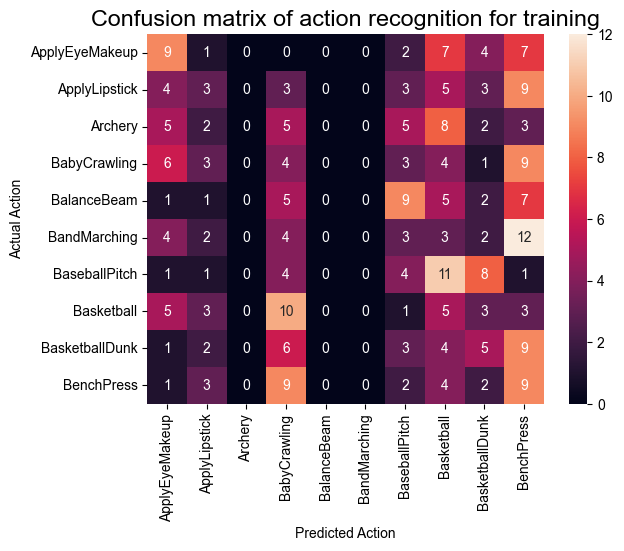

In [108]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

     13/Unknown 1s 1s/st2s 1s/st3s 1s/st4s 1s/st5s 1s/st6s 1s/st8s 1s/st9s 1s/st10s 1s/ste10s 1s/ste11s 1s/ste12s 1s/ste13s 954ms/step

c:\Python\Python 3.11.8\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 955ms/step


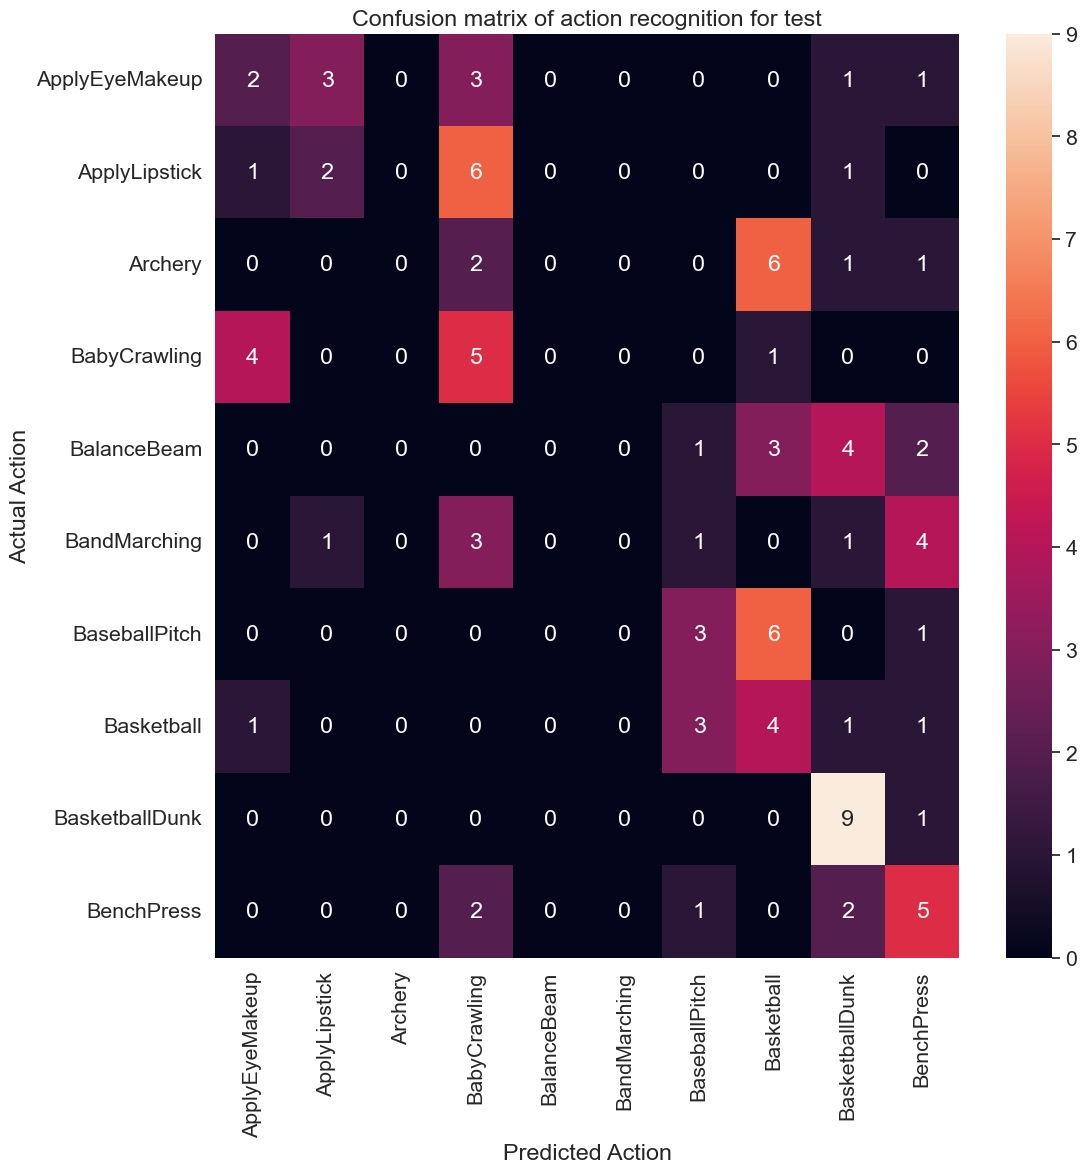

In [109]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

Значения точности и запоминаемости для каждого класса также могут быть рассчитаны с использованием матрицы путаницы.

In [110]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [111]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

C:\Users\parkh\AppData\Local\Temp\ipykernel_33612\791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [112]:
precision

{'ApplyEyeMakeup': 0.25,
 'ApplyLipstick': 0.3333333333333333,
 'Archery': nan,
 'BabyCrawling': 0.23809523809523808,
 'BalanceBeam': nan,
 'BandMarching': nan,
 'BaseballPitch': 0.3333333333333333,
 'Basketball': 0.2,
 'BasketballDunk': 0.45,
 'BenchPress': 0.3125}

In [113]:
recall

{'ApplyEyeMakeup': 0.2,
 'ApplyLipstick': 0.2,
 'Archery': 0.0,
 'BabyCrawling': 0.5,
 'BalanceBeam': 0.0,
 'BandMarching': 0.0,
 'BaseballPitch': 0.3,
 'Basketball': 0.4,
 'BasketballDunk': 0.9,
 'BenchPress': 0.5}